In [172]:
import xarray as xa
import numpy as np
import scipy as sp
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import quasibi
import networkx
import glob

In [140]:
d = xa.open_dataset("../data/data_downsampled_binned.nc").t2m

LAT, LON = np.load("../output/latlon_nodes.npz").values()

In [173]:
d.shape

(1042, 25, 40)

### Decadal Mean of Winter Temperature

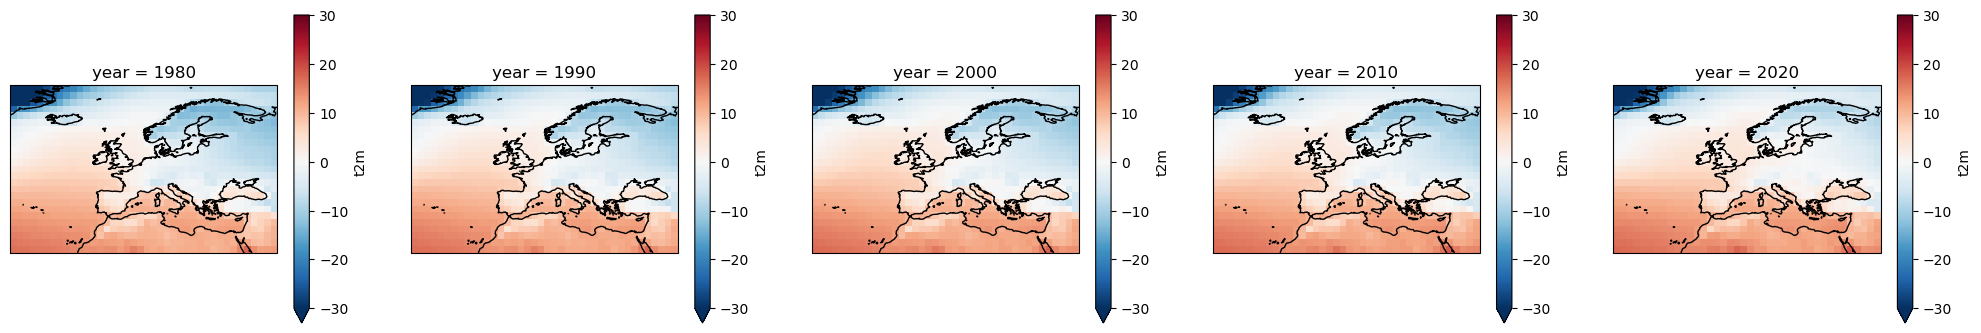

In [168]:
data = d.groupby(10*(d.time.dt.year // 10)).mean(dim="time")

fig, axs = plt.subplots(1, 5, figsize=(25, 4), subplot_kw={"projection": ccrs.PlateCarree()})

for i, ax in enumerate(axs):
    (data[i] - 278).plot(ax=ax, cmap="RdBu_r", vmin=-30, vmax=30)
    ax.coastlines()

### Yearly Mean of Winter Temperature

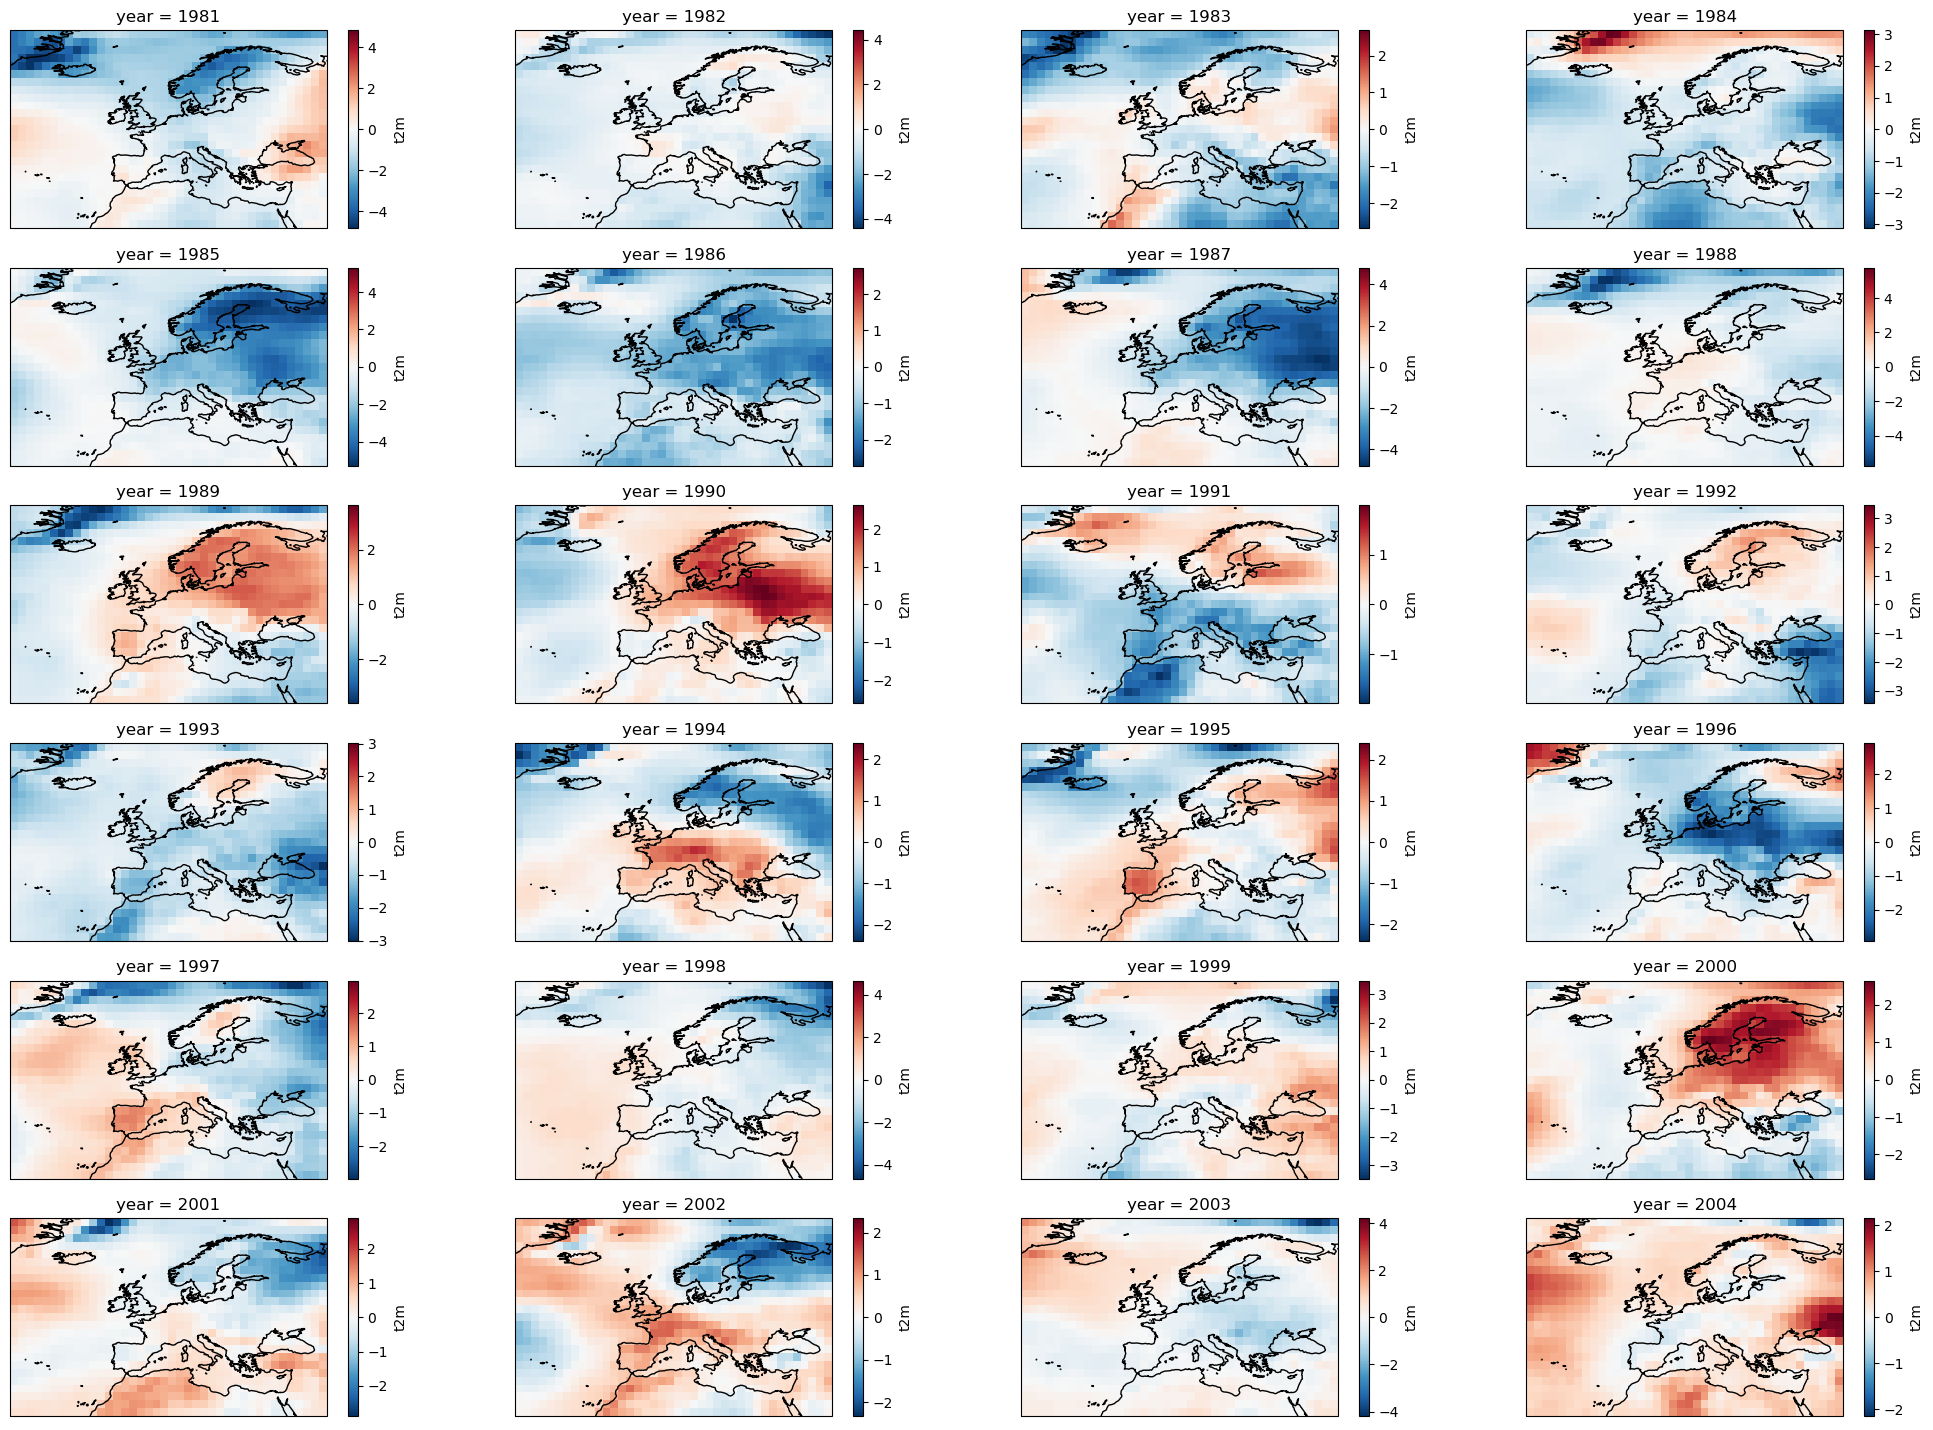

In [230]:
data = d.groupby(d.time.dt.year).mean(dim="time")
mean = d.mean(dim="time")

fig, axs = plt.subplots(6, 4, figsize=(25, 18), subplot_kw={"projection": ccrs.PlateCarree()})

for i, ax in enumerate(axs.flatten()):
    (data[i] - mean).plot(ax=ax, cmap="RdBu_r")
    ax.coastlines()

### Detrended Daily Temperature and FFT

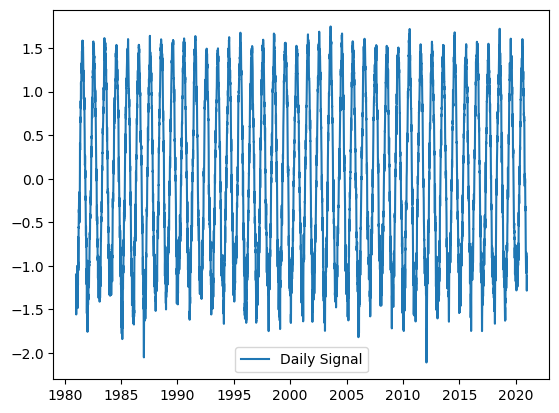

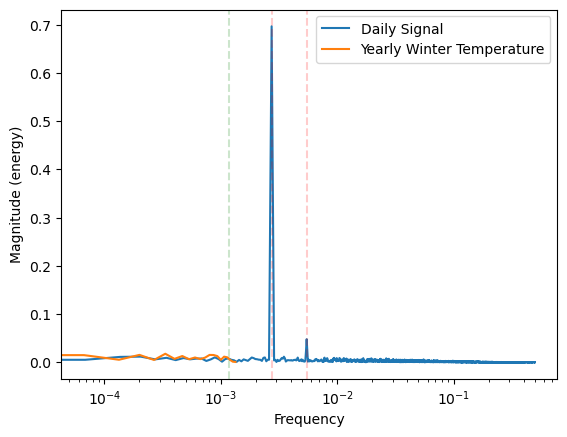

In [263]:
ds_daily = xa.open_dataset("../data/data_downsampled.nc").t2m.mean(dim=["latitude", "longitude"])
ds_daily = (ds_daily - ds_daily.mean())/ds_daily.std()
y = sp.signal.detrend(ds_daily.to_numpy())

winter = ds_daily[(ds_daily.time.dt.month <= 3) | (ds_daily.time.dt.month >= 10)]
winter = winter.groupby(winter.time.dt.year - (winter.time.dt.month < 3)).mean()
winter = sp.signal.detrend(winter.to_numpy())

plt.plot(ds_daily.time, y, label="Daily Signal")
plt.legend()
plt.show()

plt.magnitude_spectrum(y, Fs=1, label="Daily Signal")
plt.magnitude_spectrum(winter, Fs=1/365, label="Yearly Winter Temperature")

plt.semilogx()
plt.axvline(1/365, c="red", ls="--", alpha=.2)
plt.axvline(2/365, c="red", ls="--", alpha=.2)
plt.axvline(1/(365*28/12), c="green", ls="--", alpha=.2)
plt.legend()
plt.show()

### Detrended Yearly Temperature and FFT

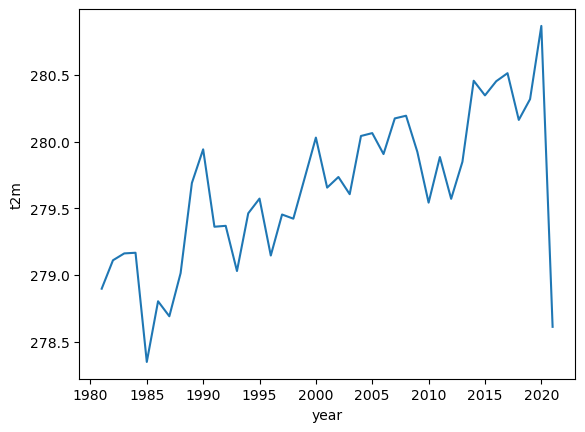

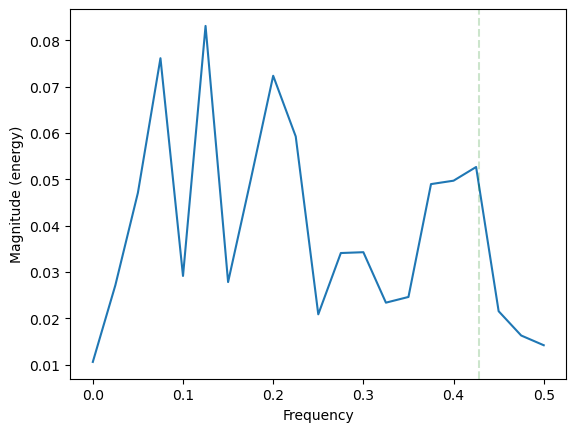

In [225]:
data = d.groupby(d.time.dt.year).mean(dim="time").mean(dim=["latitude", "longitude"])
data.plot()
plt.show()

data = sp.signal.detrend(data[:-1].to_numpy())
plt.magnitude_spectrum(data, Fs=1)
plt.axvline(12/28, c="green", ls="--", alpha=.2)
plt.show()

### Degree for the Static Network

In [128]:
pearson = quasibi.load_symmat("../output/pearson_correlation_matrix.npy")
pearson = np.abs(pearson) >= np.quantile(np.abs(pearson), 1 - 0.005)

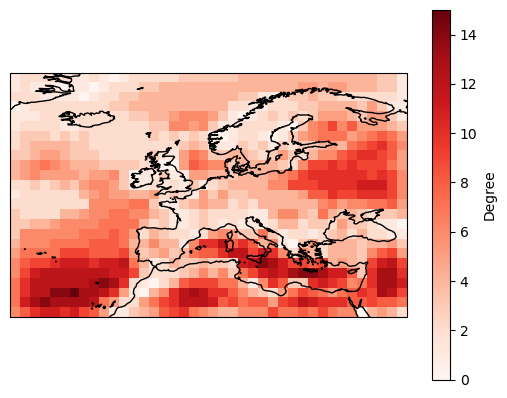

In [159]:
net = networkx.from_numpy_matrix(pearson)
deg = np.fromiter(dict(networkx.degree(net)).values(), "int").reshape((25, 40))

ax = plt.subplot(111, projection=ccrs.PlateCarree())
cmap = ax.imshow(deg, extent=[LON.min(), LON.max(), LAT.min(), LAT.max(),], cmap="Reds")
plt.colorbar(cmap, label="Degree")

ax.coastlines()